# Visualize model predictions for thesis

Ensure that samples entered are in the test set or validation set

In [26]:
import sys
from pytorch_lightning import Trainer
import albumentations as A
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl
import numpy as np

sys.path.append('.')
#from models.UNet_mateuszbuda import UNet_m
from models.UNet_L import UNet_no_val
from models.loss import DiceLoss, DiceLoss2

from run_pretraining import get_dataset

from data.CTDataSet import CTDicomSlices, DatasetManager
from data.CustomTransforms import Window, Imagify, Normalize

from tests.test_CTDataSet import plot_slices_and_mask

### Plotting function

In [ ]:
save_plots = False
plot_save_folder = '/mnt/c/Users/Hussam/Documents/Masters thesis/Result graphs'

In [28]:
def plot_img_and_mask(img, prediction, mask, n = 1, title = 'My Figure Title'):
    #mask = mask * 255 // 4
    #prediction = prediction * 255 // 4
    
    fig = plt.figure(figsize=(21, (n * 5) + 1))   # need to specify figure height. 6 per slice, +1 for header
    cols, rows = 3, n     # row per slice
  
    fig.patch.set_facecolor('white')
    
    for i in range(n):
        img_ = img[i].numpy()
        mask_ = mask[i].numpy()
        prediction_ = prediction[i].numpy()

        fig.add_subplot(rows, cols, i * 3 + 1)    # matplotlib uses 1-based indexing to number figures. for example, for 3 slices
        plt.title('CT Slice')                     # the indices will be 1-3 (3 figures per slice)
        plt.imshow(img_, cmap='gray')
        
        fig.add_subplot(rows, cols, i * 3 + 2)
        plt.title('Prediction')
        plt.imshow(img_, cmap='gray')
        plt.imshow(prediction_, cmap='jet', alpha=0.3)
        
        fig.add_subplot(rows, cols, i * 3 + 3)
        plt.title('Ground truth')
        plt.imshow(img_, cmap='gray')
        plt.imshow(mask_, cmap='jet', alpha=0.3)


    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    if save_plots:
        save_path = "{}/segmentation_result-{}.png".format(plot_save_folder, title)
        plt.savefig(save_path, bbox_inches='tight')

    plt.show()

### Some constants

In [29]:
img_size = 256

def to_float(x, **kwargs):
    return x.astype('float32')

### Create the relevant transforms

In [30]:
test_set = True
WL = 50
WW = 200
mean = 61.0249
std = 78.3195

In [31]:
img_mask_tsfm = A.Compose([A.Resize(img_size, img_size)], 
            additional_targets={"image1": 'image', "mask1": 'mask'})

prep = transforms.Compose([Window(WL, WW), Imagify(WL, WW), Normalize(mean, std)])

resize_tsfm = A.Compose([A.Resize(img_size, img_size)],
            additional_targets={"image1": 'image', "mask1": 'mask'})

### Build the relevant datasets

In [32]:
model_dir = "/mnt/d/model_runs2024/model_runs/2024-11-17-19_13_59"
checkpoint_f = '/mnt/d/model_runs2024/model_runs/2024-11-17-19_13_59/logs/lightning_logs/version_0/checkpoints/best-epoch=25.ckpt'

#dataset = "../organized_dataset_2"
dataset = '/home/hussam/imager/organized_dataset_2'

if test_set:
    dsm = DatasetManager.load_train_val_test(dataset, "{}/train.txt".format(model_dir), "{}/val.txt".format(model_dir), "{}/test.txt".format(model_dir))

    train_dicoms, val_dicoms, test_dicoms = dsm.get_dicoms() # DICOM glob is preset in the class file

    test_ds = CTDicomSlices(test_dicoms, img_and_mask_transform = img_mask_tsfm, preprocessing=prep)

    test_dl = DataLoader(test_ds, batch_size=1, num_workers = 0, shuffle=True)
else:
    dcm_list = CTDicomSlices.generate_file_list(dataset, dicom_glob='/*/dicoms/*.dcm')
    ds = CTDicomSlices(dcm_list, preprocessing = prep,
                        resize_transform = resize_tsfm, n_surrounding=1, mask_is_255=False)
                        
    test_dl = DataLoader(ds, batch_size = 1, num_workers = 0, shuffle = True)

In [33]:
#model = UNet_no_val.load_from_checkpoint(checkpoint_f, datasets=None, in_channels=3, classes=2)

loss = DiceLoss()
loss2 = DiceLoss2()

In [34]:
def plot_slices(slices_l, mask_l, img_path_l, model, title = ""):
    y_pred = map(model, slices_l)

    #y_pred_img_only = y_pred[0,0,:,:]

    #print("Mask sum is {} and max is {}".format(torch.sum(mask), torch.max(mask)))
    #dice_score = 1 - model.loss(y_pred, mask)

    #print("Model WL: {} - WW: {}".format(WL, WW))
    #print("Input file is: {}".format(img_path))
    #print("Dice score 2 is: {:.3f}%".format(dice_score * 100))
    
    plot_img_and_mask([s[0,:,:,1] for s in slices_l], [torch.round(x[0,0,:,:].detach()) for x in y_pred],
                      [m[0] for m in mask_l], n = len(slices_l), title = title)

In [35]:
dcm_list = ["/home/hussam/imager/organized_dataset_2/HNSCC-01-0608/dicoms/179.dcm",
            "/home/hussam/imager/organized_dataset_2/HNSCC-01-0538/dicoms/130.dcm",
            "/home/hussam/imager/organized_dataset_2/HNSCC-01-0465/dicoms/146.dcm",
            "/home/hussam/imager/organized_dataset_2/HNSCC-01-0540/dicoms/125.dcm"]

ds = CTDicomSlices(dcm_list, preprocessing = prep,
                resize_transform = resize_tsfm, n_surrounding=1, mask_is_255=False)
                        
test_dl = DataLoader(ds, batch_size = 1, num_workers = 0, shuffle = False)

In [36]:
model_list = [('ImageNet weights', "/mnt/d/model_runs2024/model_runs/2024-11-17-19_13_59", '/mnt/d/model_runs2024/model_runs/2024-11-17-19_13_59/logs/lightning_logs/version_0/checkpoints/best-epoch=25.ckpt'),
              ('Random weights', 'model_runs2024/model_runs/2024-11-17-19_13_59', '/mnt/d/model_runs2024/model_runs/2024-11-17-19_13_59/logs/lightning_logs/version_0/checkpoints/best-epoch=25.ckpt'),
              ('Segmentation pretraining', '/mnt/d/pretrainer-2/model_runs/2021-05-19-15_14_53', '/mnt/d/pretrainer-2/model_runs/2021-05-19-15_14_53/logs/default/version_0/checkpoints/epoch=99-step=250299.ckpt'),
              ('Jigsaw pretraining', '/mnt/d/pretrainer/model_runs/best_model', '/mnt/d/pretrainer/model_runs/best_model/logs/default/version_0/checkpoints/epoch=99-step=226899.ckpt'),
              ('JigsawSR pretraining', '/mnt/d/model_runs2024/model_runs/2025-04-09-04_28_03', '/mnt/d/model_runs2024/model_runs/2025-04-09-04_28_03/logs/lightning_logs/version_0/checkpoints/last-epoch=99.ckpt')]



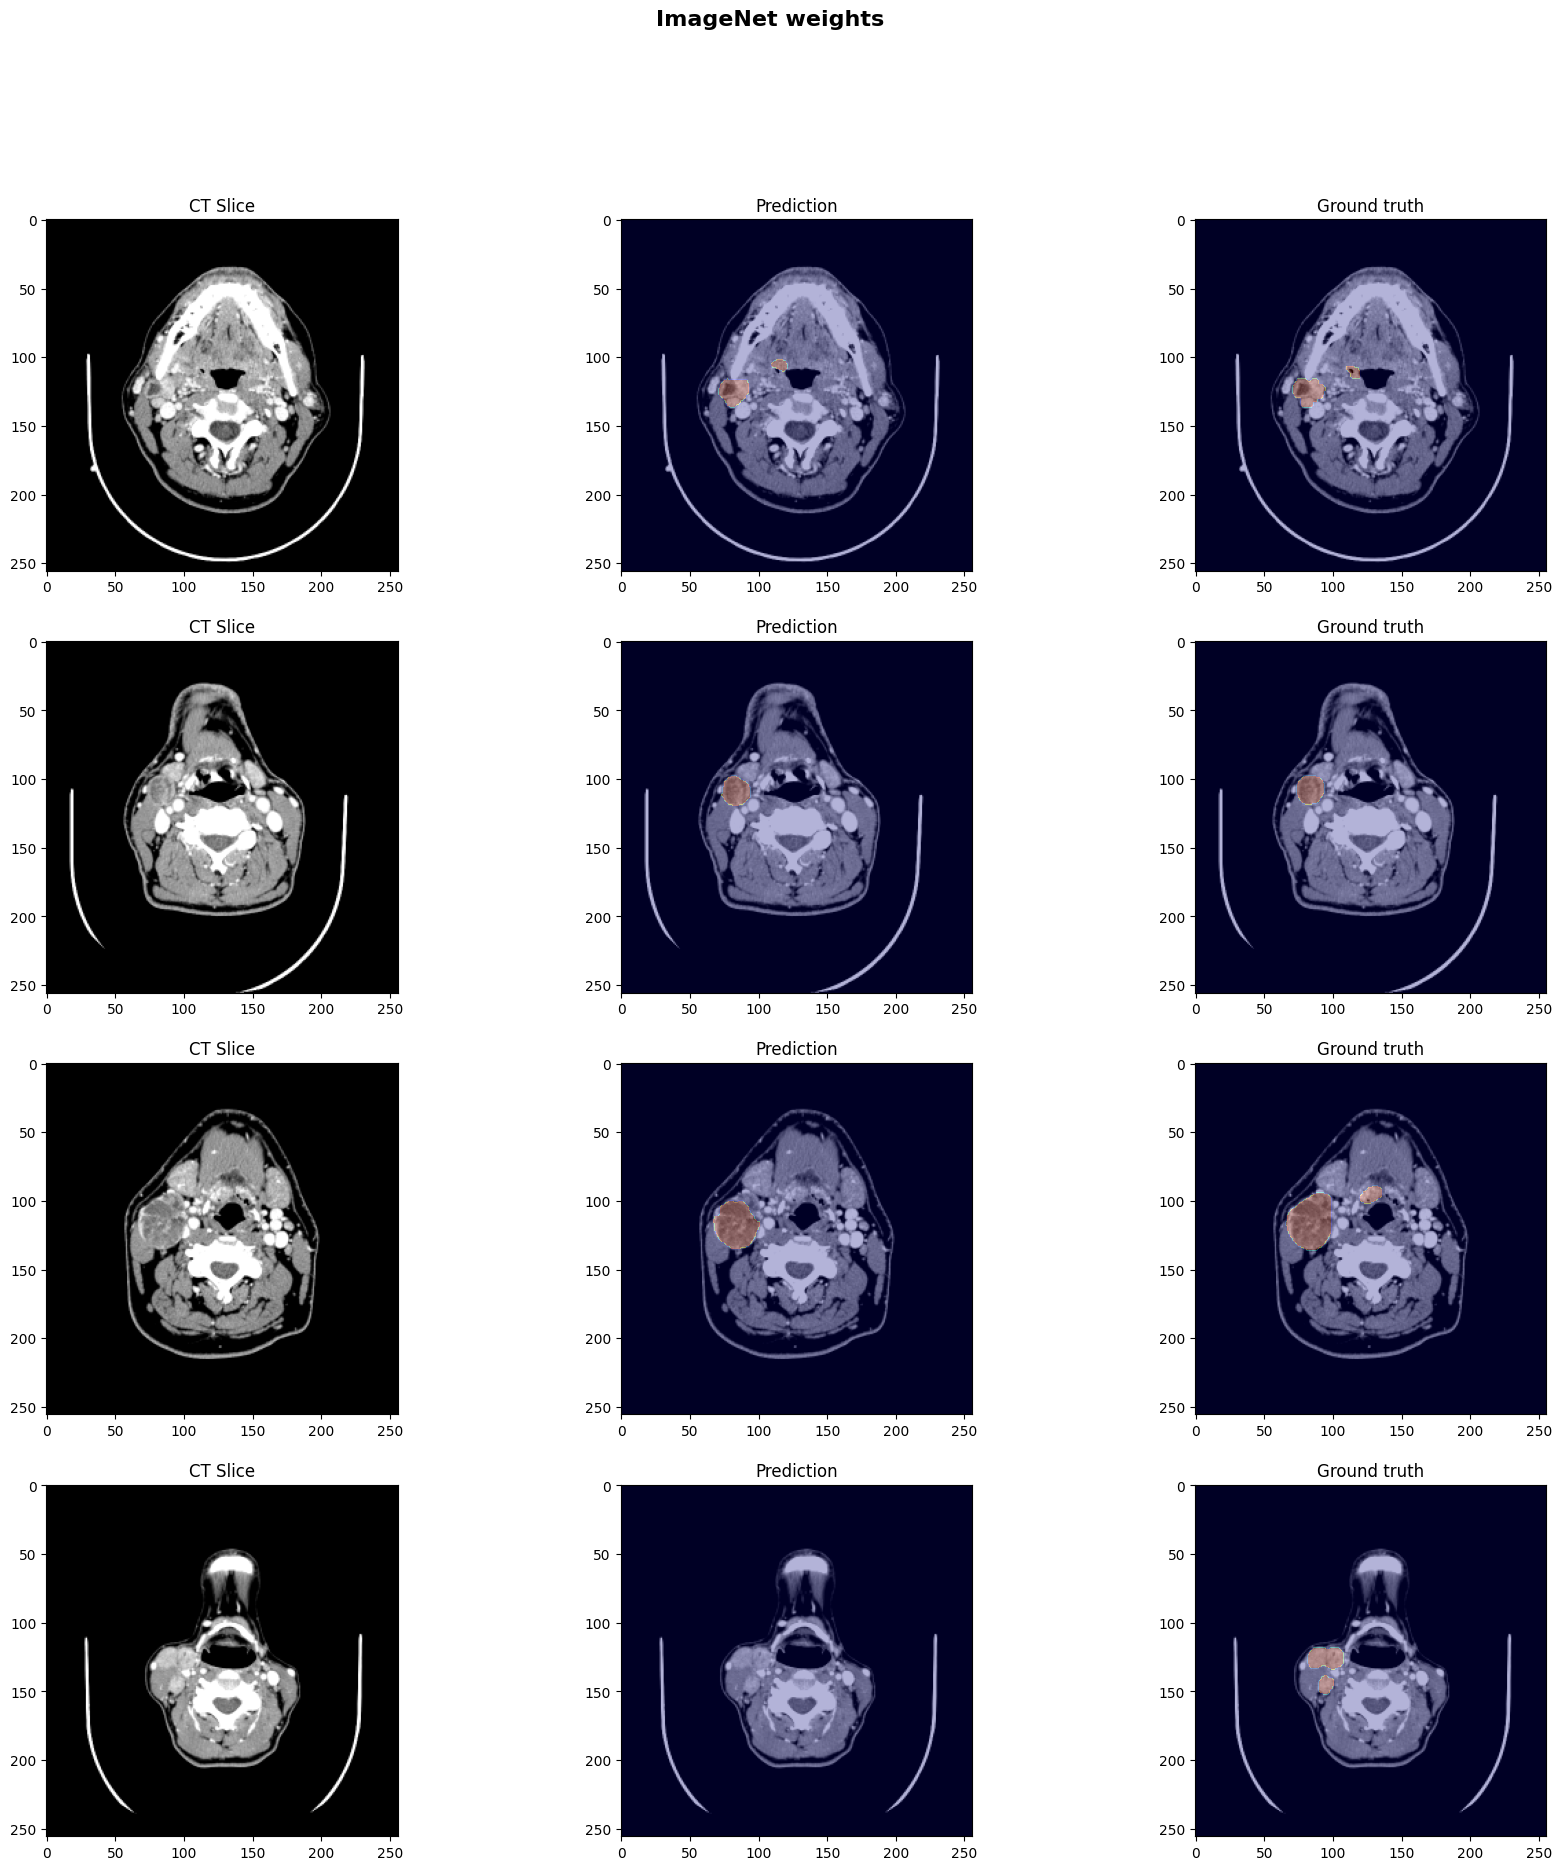

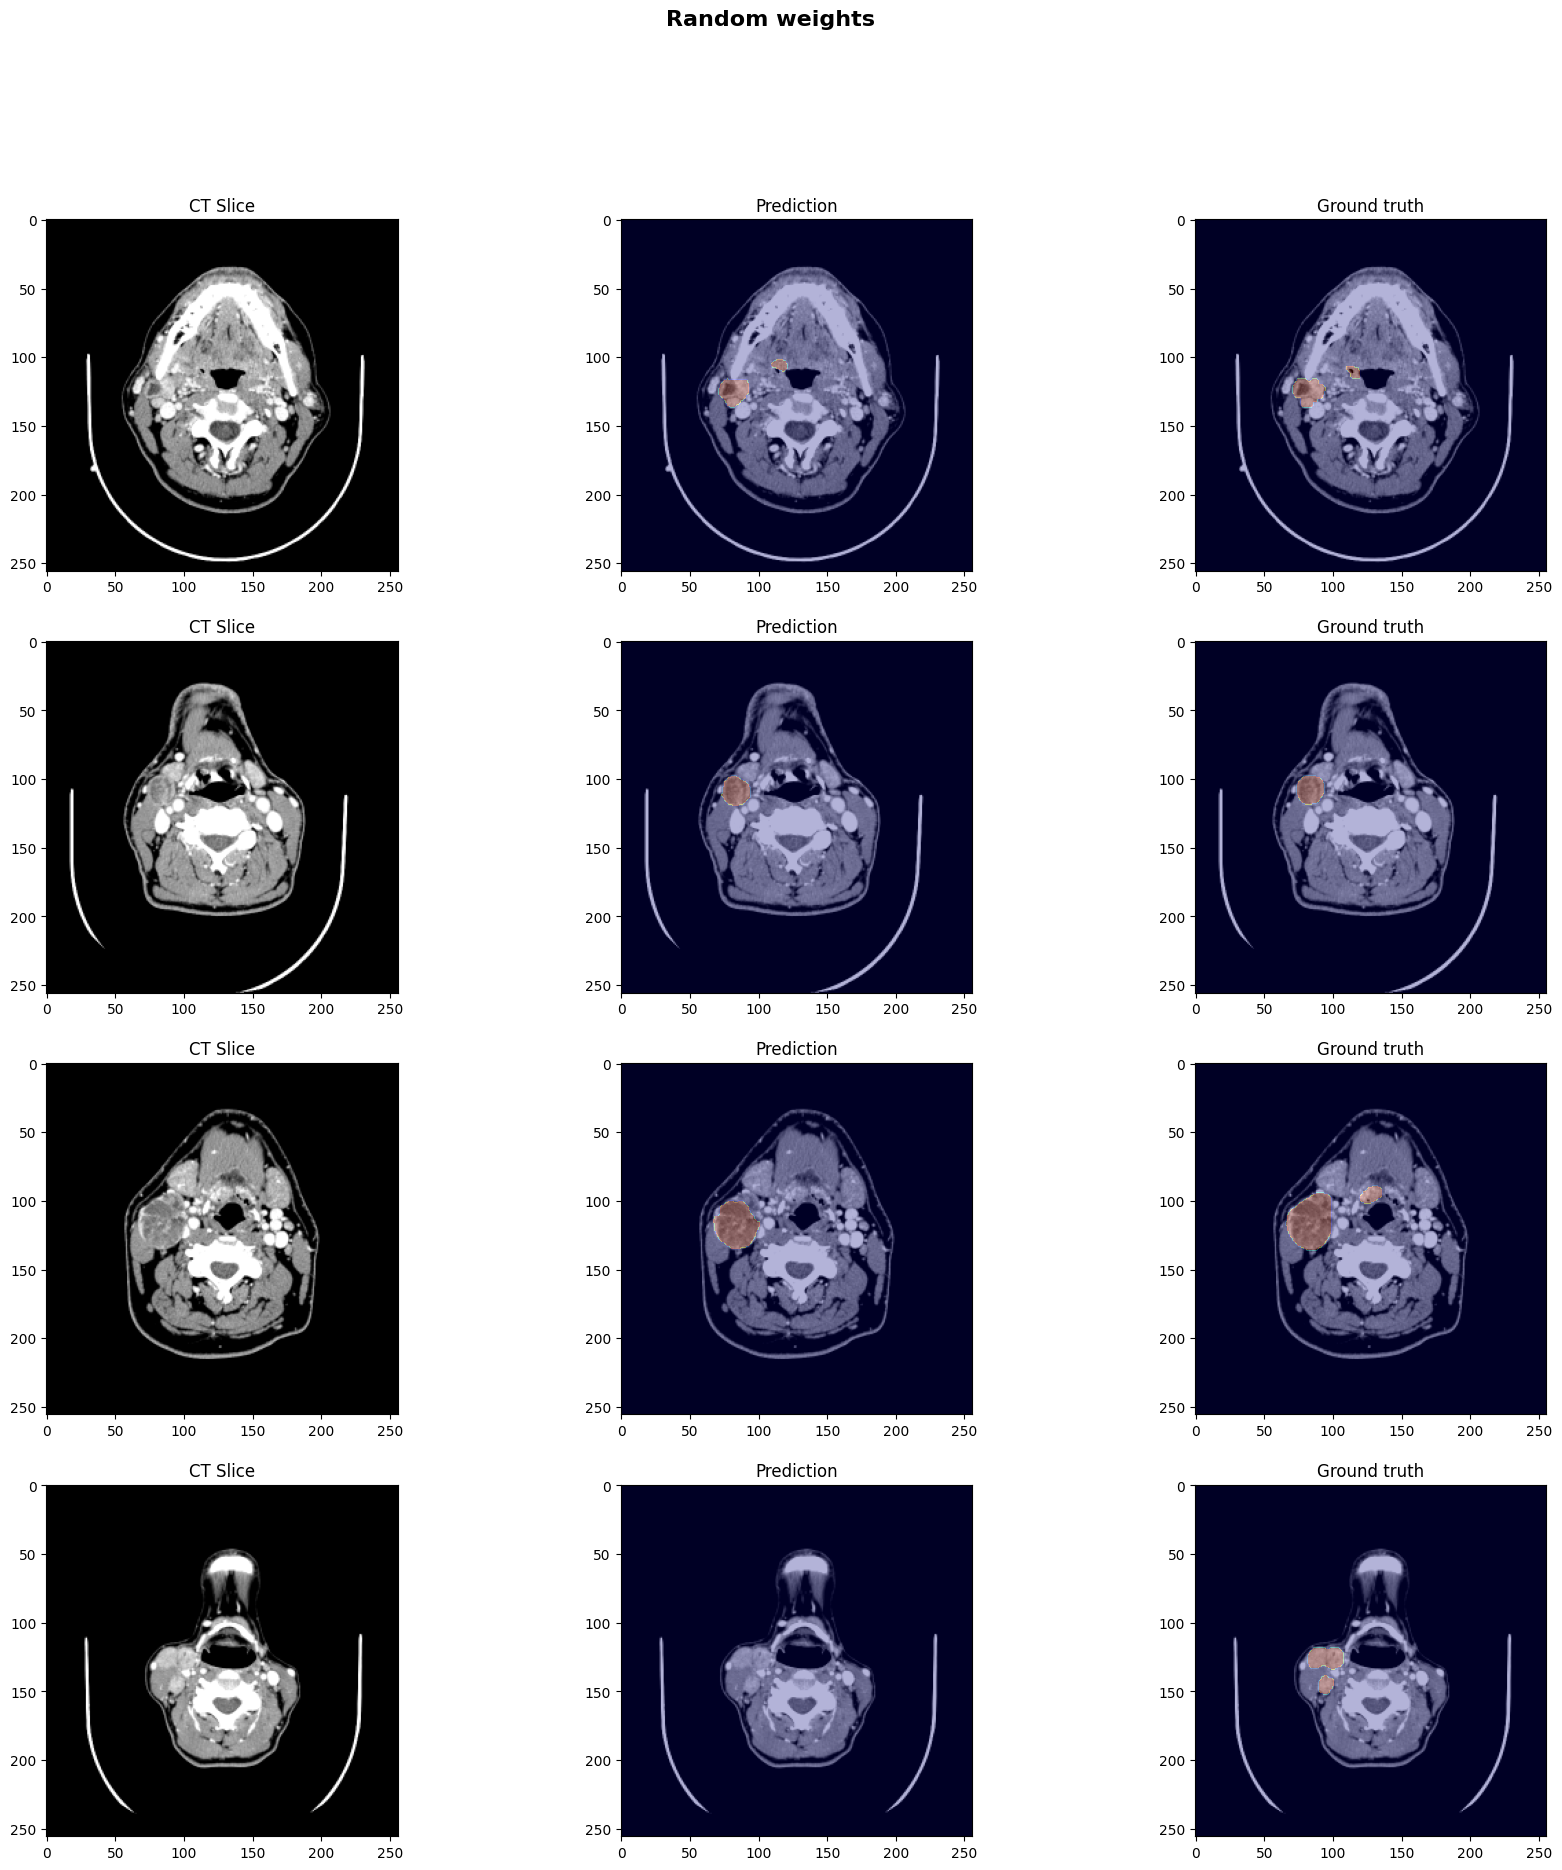

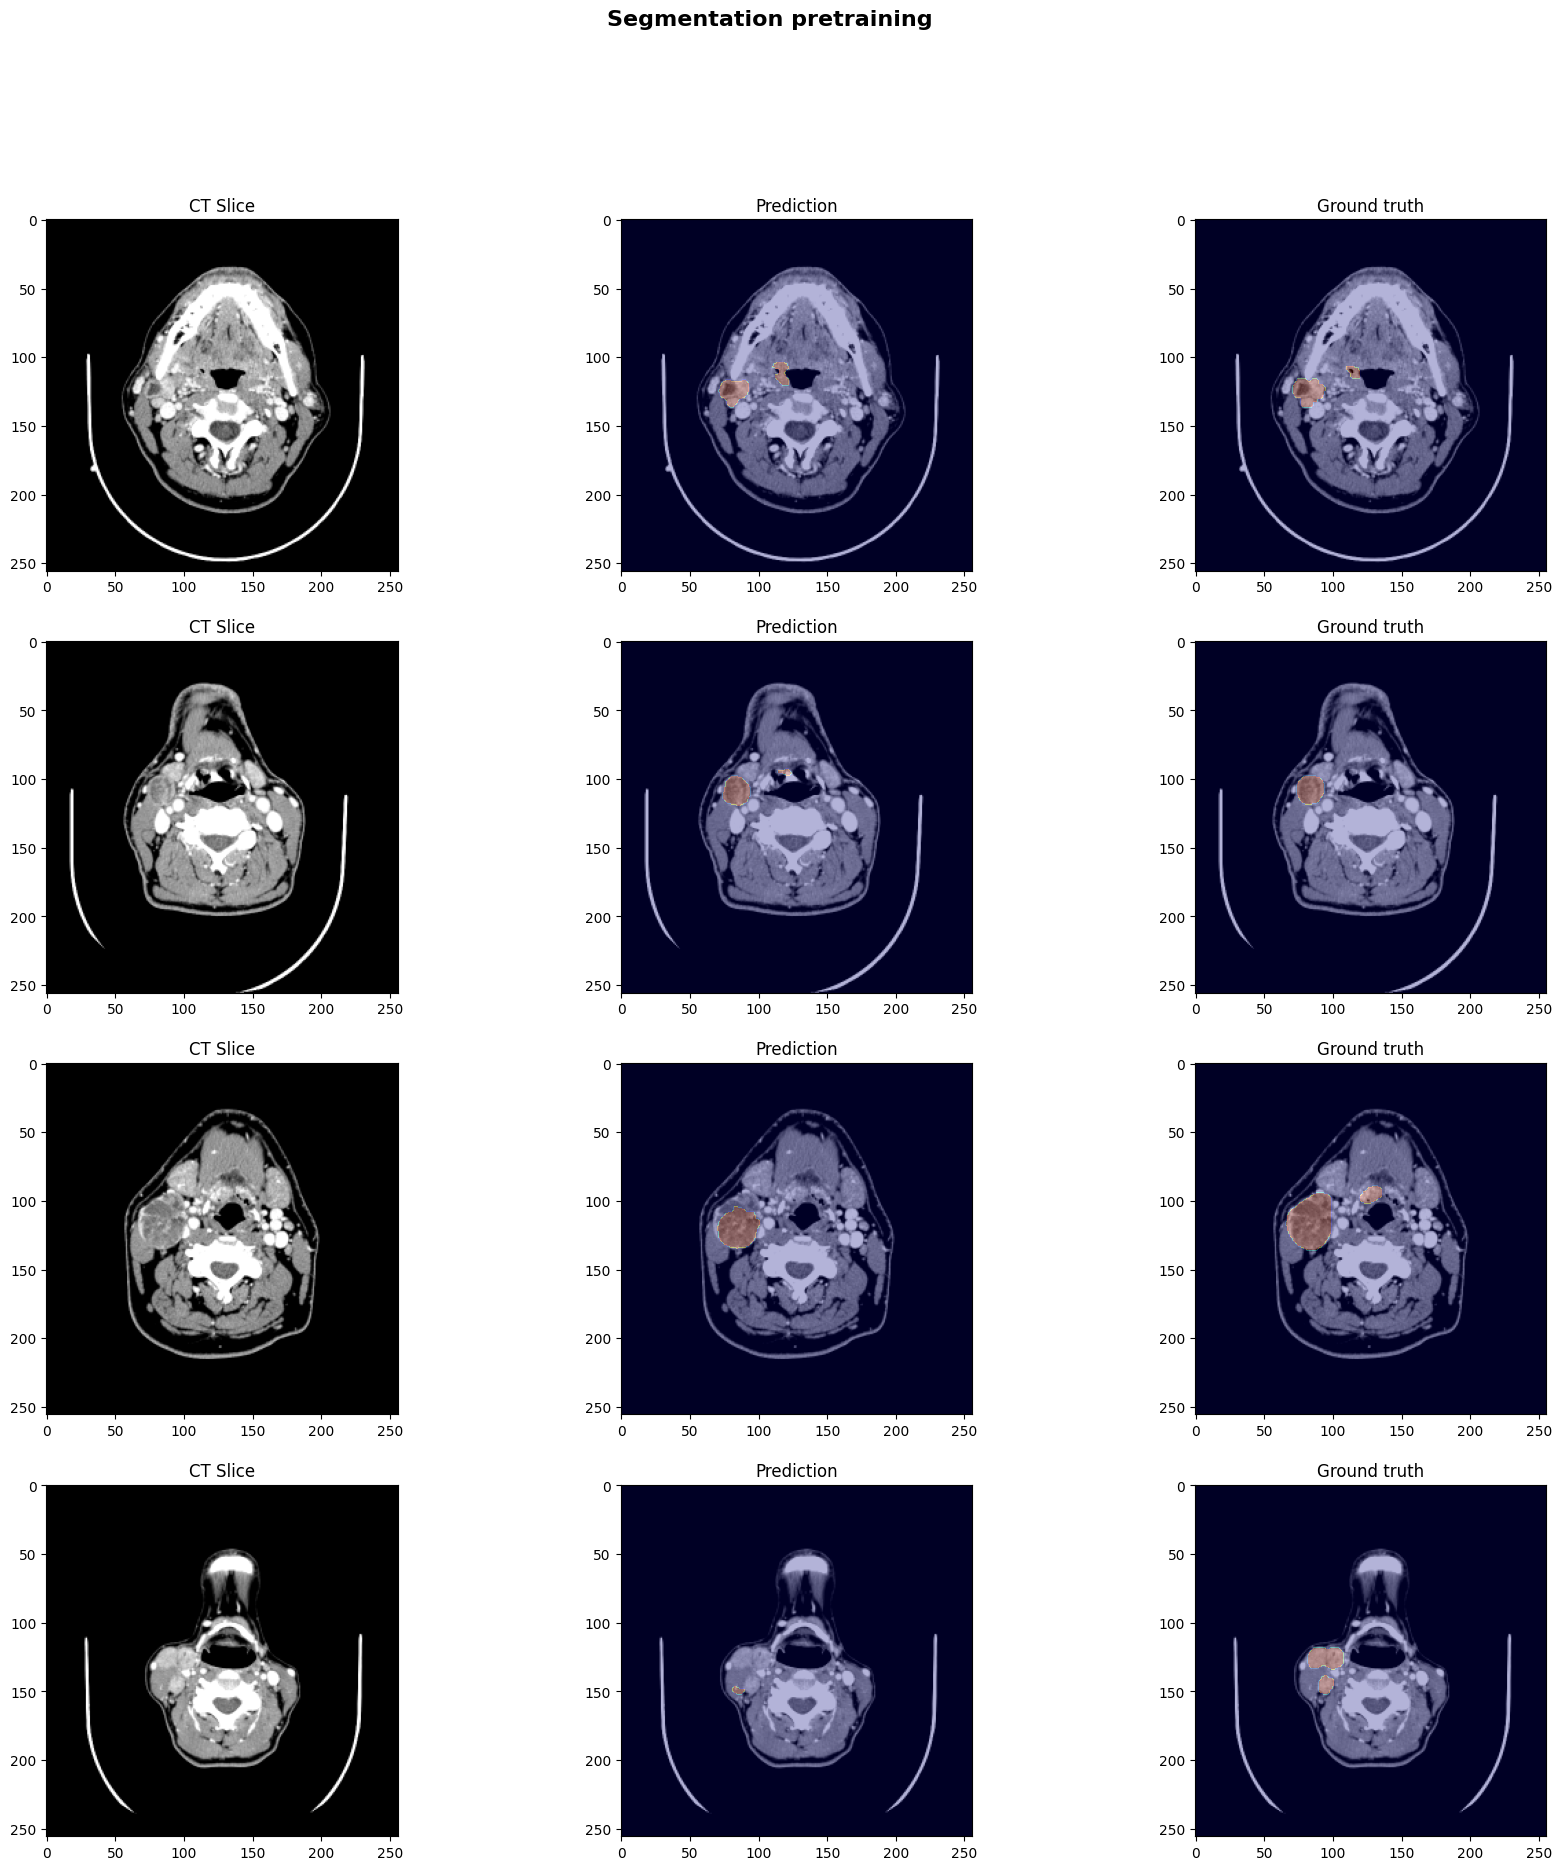

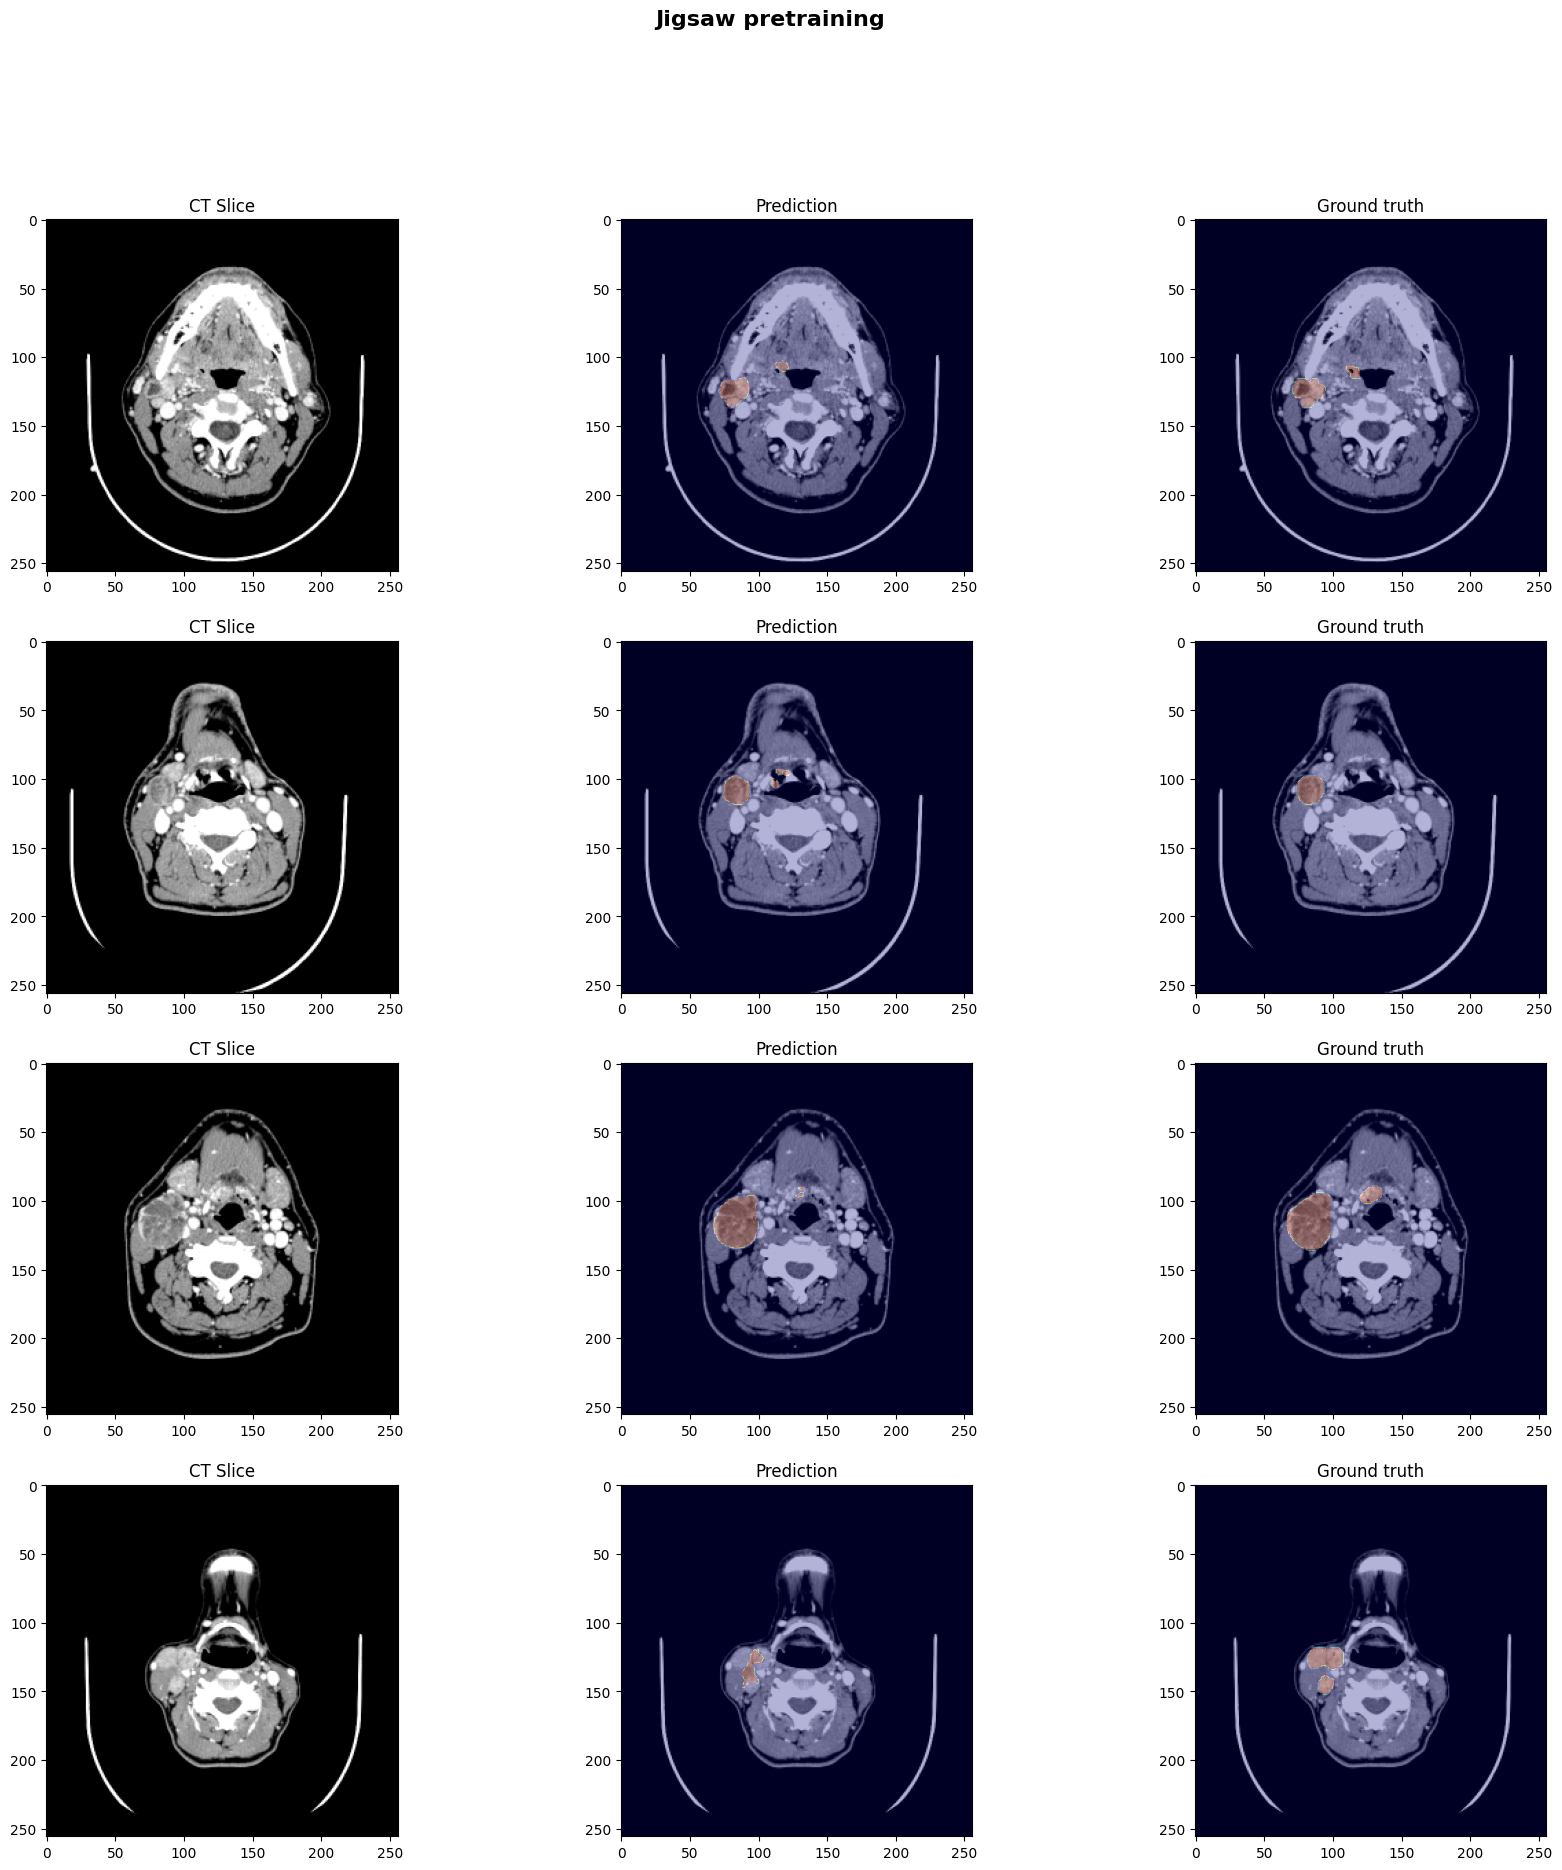

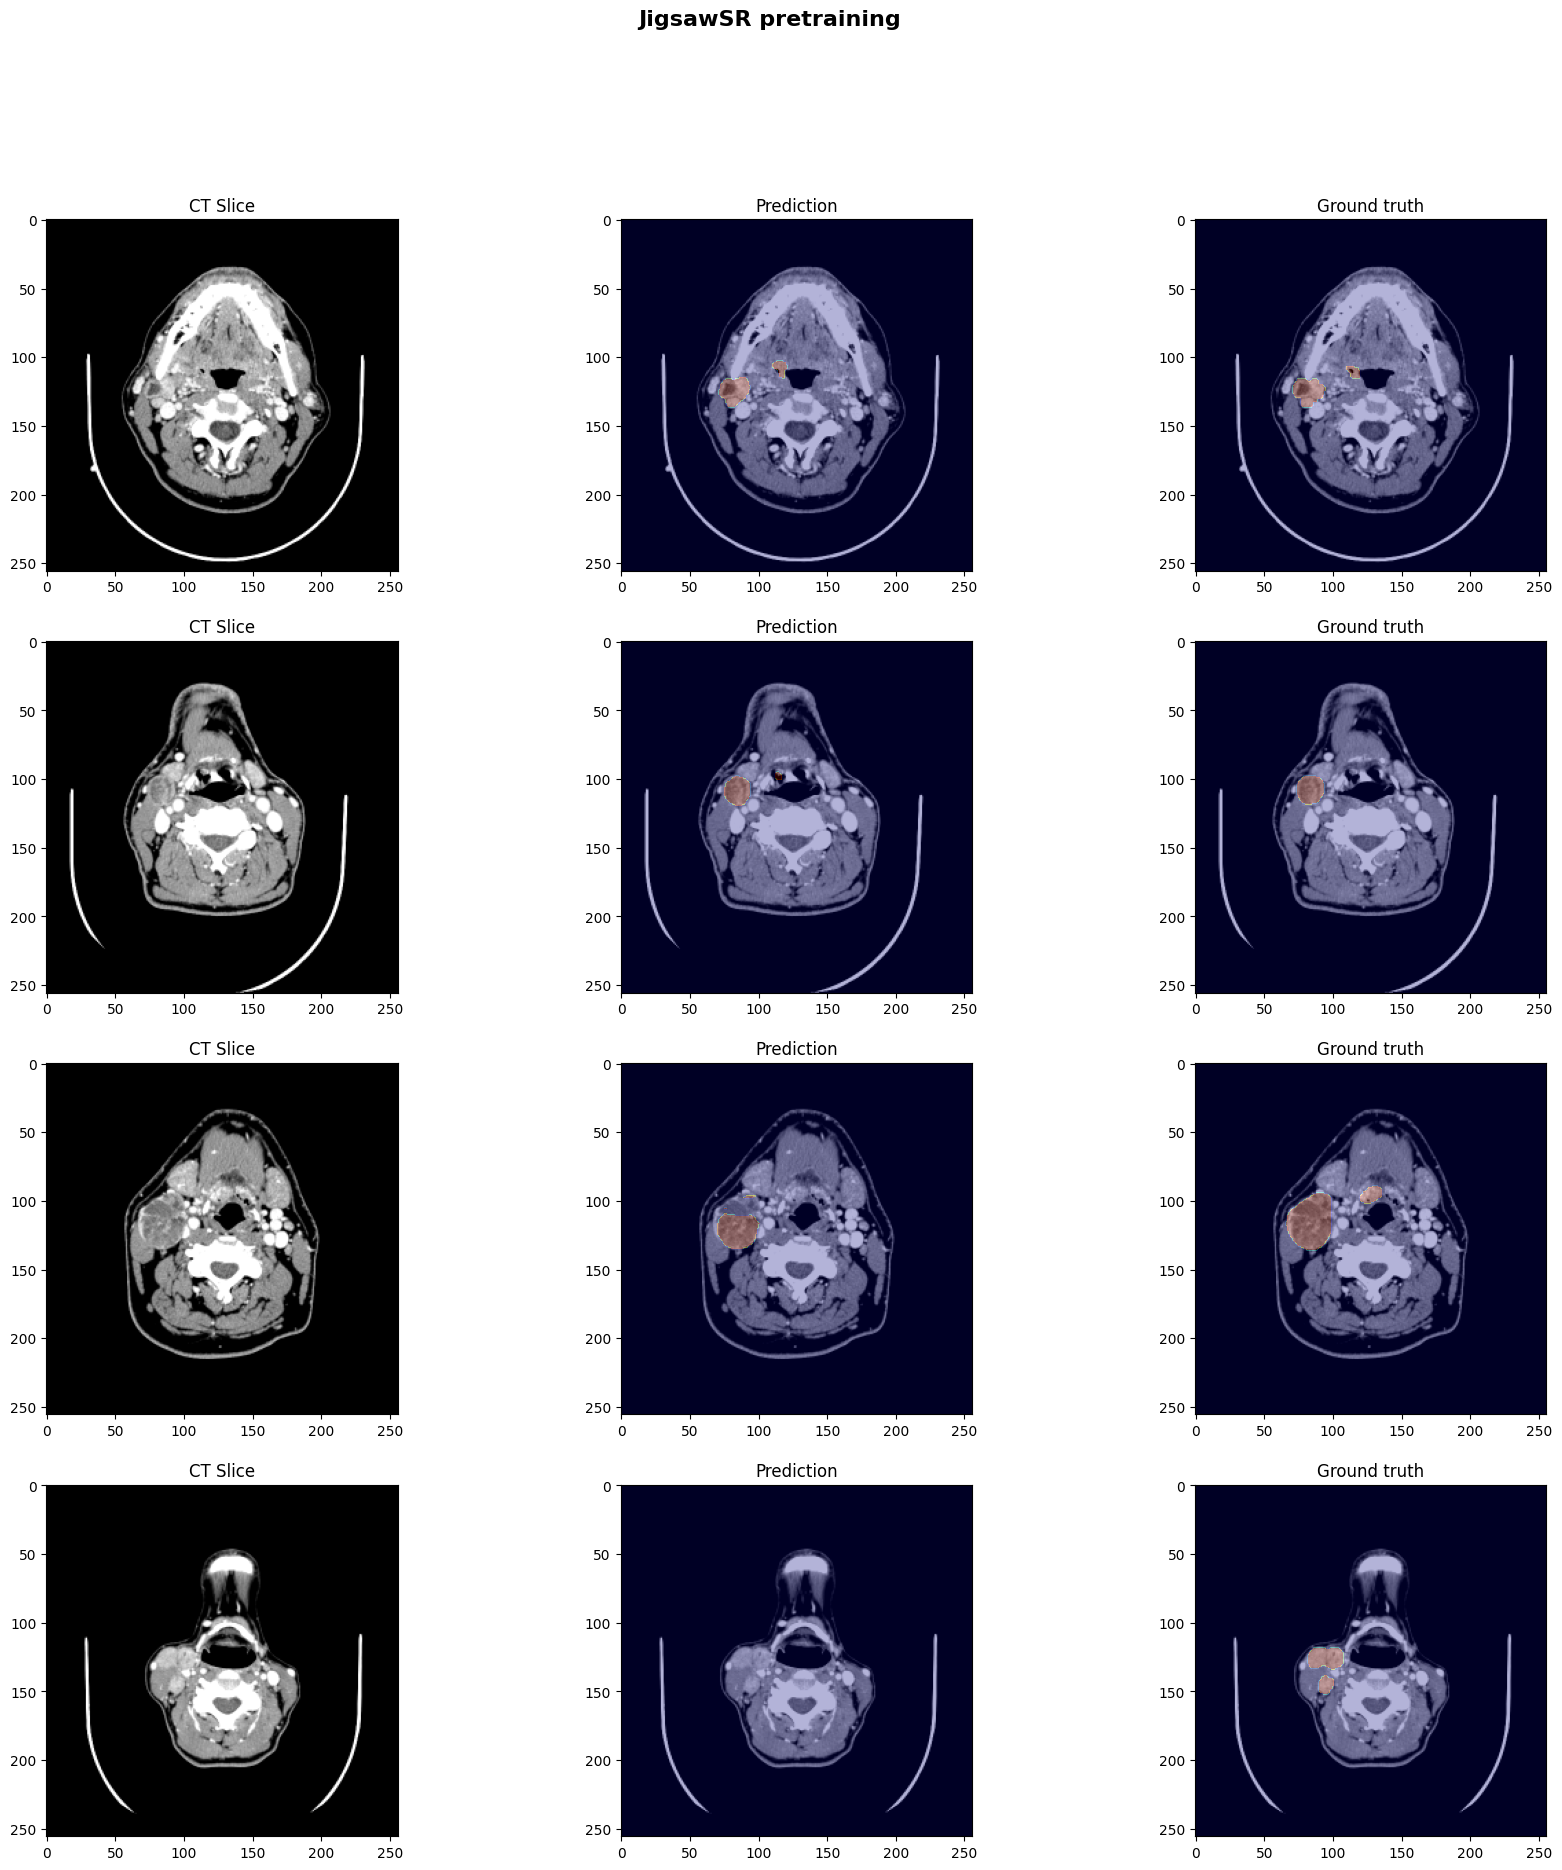

In [37]:
for model_t in model_list:
    slices_l = []
    mask_l = []
    img_path_l = []

    model = UNet_no_val.load_from_checkpoint(model_t[2], datasets=None, in_channels=3, classes=2)

    for i, (slices, mask, img_path, _) in enumerate(test_dl):
        slices_l.append(slices)
        mask_l.append(mask)
        img_path_l.append(img_path)
            
    plot_slices(slices_l, mask_l, img_path_l, model, title = model_t[0])
